In [4]:
import numpy as np
from nptyping import NDArray
import random
import numpy.linalg as LA
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional, Any, Callable
from utils import load_image_to_arr, display_rgb, SVD2D

(540, 960, 3)


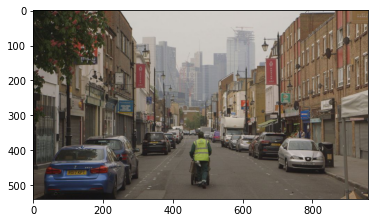

In [5]:
I = load_image_to_arr("street.jpg")
print(I.shape)
display_rgb(I)

In [6]:
class ImageAtScale:
    def __init__(self, imageChunk: NDArray[Any], anchor: Tuple[int, int]):
        self.imageChunk: NDArray[Any] = imageChunk
        self.imageSize: int = imageChunk.shape[0]
        self.anchor: Tuple[int, int] = anchor

        pass



class ImageChunkAttributeSummarizer:
    def __init__(self, chunks: List[ImageAtScale], attribute_size: int, is_metadata: bool, description: str = "no summary"):
        self.description: str = description
        self.chunks: List[ImageAtScale] = chunks
        self.n_chunks: int = len(chunks)
        self.attribute_size = attribute_size
        self.is_metadata = is_metadata
        self.summary: NDArray[Any] = None

    def calculate_summary(self) -> NDArray[Any]:
        pass


class ImageChunkMeanSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], description: str = "Image Chunk RGB Mean"):
        super().__init__(chunks, 3, False, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))

    def calculate_summary(self):
        imgs: List[NDArray[Any]] = [c.imageChunk for c in self.chunks]
        for i in range(self.n_chunks):
            img: NDArray[Any] = imgs[i]
            m = np.mean(img, axis=(0, 1))
            self.summary[i] = m

class ImageChunkPrincipleColorSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], principle_color_index: int, description: str = "The nth priciple color and it's standardized length") -> None:
        self.principle_color_index = principle_color_index
        super().__init__(chunks, 4, True, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))

    def calculate_summary(self) -> NDArray[Any]:
        img_area_2d = self.chunks[0].imageChunk.shape[0] * self.chunks[0].imageChunk.shape[1]
        for i in range(self.n_chunks):
            img = self.chunks[i].imageChunk
            colors = img.reshape(img_area_2d, 3)
            colors_mean = np.mean(colors, axis=0)
            colors_mean_rem = colors - colors_mean
            color_svd = SVD2D(colors_mean_rem)
            principle_color = color_svd.VT[self.principle_color_index] 
            pc_len = color_svd.s[self.principle_color_index]
            std_pc_len = ((pc_len ** 2) / (img_area_2d * 3)) ** 0.5
            
            self.summary[i, 0] = std_pc_len
            self.summary[i, 1:] = principle_color

class ImageChunkAnchorSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], description: str = "Image Chunk RGB Mean") -> None:
        super().__init__(chunks, 2, True, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))
    
    def calculate_summary(self):
        for i in range(self.n_chunks):
            self.summary[i, 0] = self.chunks[i].anchor[0]
            self.summary[i, 1] = self.chunks[i].anchor[1]

class ImageChunkCenterLocationSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], description: str = "Image Chunk RGB Mean") -> None:
        super().__init__(chunks, 2, False, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))
    
    def calculate_summary(self):
        center_offset = self.chunks[0].imageSize / 2
        for i in range(self.n_chunks):
            self.summary[i, 0] = self.chunks[i].anchor[0] + center_offset
            self.summary[i, 1] = self.chunks[i].anchor[1] + center_offset

    


class MultiScaleImageChunkSummarizer:
    def __init__(self):
        pass

class ImageChunkSummarizer:
    def __init__(self):
        pass

    def encode_summaries(self, chunks: List[ImageAtScale]):
        pass




class MultiScaleImageSampler:
    def __init__(self, scales: List[int]) -> None:
        #pre-condition: All scales are even numbers.
        self.scales: List[int] = scales
        self.num_scales: int = len(scales)
        self.first_scale = scales[0]

    def sample(self, image: NDArray[Any]) -> List[ImageAtScale]:
        imgY = image.shape[0]
        imgX = image.shape[1]
        anchors: List[Tuple[int, int]] = []
        result: List[ImageAtScale] = []
        
        first_anchor_X = random.randint(0, imgX - self.first_scale)
        first_anchor_Y = random.randint(0, imgY - self.first_scale)
        anchors.append((first_anchor_X, first_anchor_Y))

        for i in range(1, self.num_scales):
            prev_anchor_x, prev_anchor_y = anchors[i-1]
            prev_scale = self.scales[i-1]
            scale = self.scales[i]
            anchor_x = prev_anchor_x + ((prev_scale - scale) // 2)
            anchor_y = prev_anchor_y + ((prev_scale - scale) // 2)
            anchors.append((anchor_x, anchor_y))
    
        for i in range(self.num_scales):
            anchor_x, anchor_y = anchors[i]
            scale = self.scales[i]
            chunk = image[anchor_y:anchor_y+scale, anchor_x:anchor_x+scale, :]
            result.append(ImageAtScale(chunk, anchors[i]))
        
        return result
        

(128, 128, 3) (64, 64, 3) (32, 32, 3) (8, 8, 3)


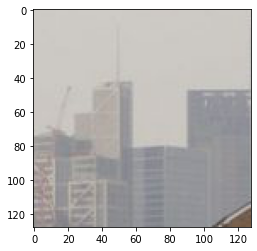

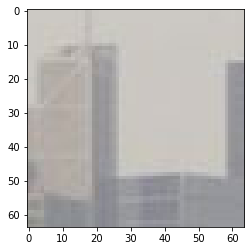

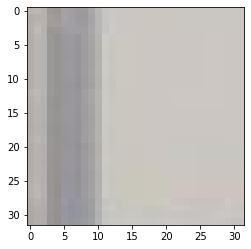

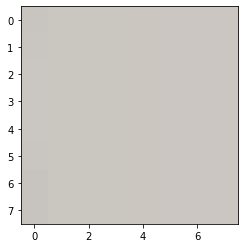

In [7]:
sampler = MultiScaleImageSampler([128, 64, 32, 8])
scales = sampler.sample(I)
print(
    scales[0].imageChunk.shape,
    scales[1].imageChunk.shape,
    scales[2].imageChunk.shape,
    scales[3].imageChunk.shape
)
display_rgb(scales[0].imageChunk)
display_rgb(scales[1].imageChunk)
display_rgb(scales[2].imageChunk)
display_rgb(scales[3].imageChunk)

In [8]:
mean_summarizer = ImageChunkMeanSummarizer([scales[0]])
mean_summarizer.calculate_summary()
mean_summarizer.summary

array([[176.90161133, 174.44061279, 172.97705078]])

64


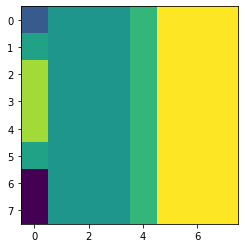

In [9]:
scale = scales[-1]
img = scale.imageChunk
img_area_2d = scale.imageSize ** 2
print(img_area_2d)
principle_color_index = 0

colors = img.reshape(img_area_2d, 3)
colors_mean = np.mean(colors, axis=0)
colors_mean_rem = colors - colors_mean
color_svd = SVD2D(colors_mean_rem)
principle_color = color_svd.VT[principle_color_index] 
pc_len = color_svd.s[principle_color_index]
std_pc_len = ((pc_len ** 2) / (img_area_2d * 3)) ** 0.5

u = color_svd.U[:, principle_color_index]
PCM = u.reshape((scale.imageSize, scale.imageSize))

fig, ax = plt.subplots()
ax.imshow(PCM)

(8, 8)
[[ 0.     -0.8147  0.2037  0.1549]
 [ 0.0797  0.1105  0.1041  0.0937]
 [-0.1437 -0.1993 -0.1877 -0.1689]
 [-0.0134 -0.0186 -0.0176 -0.0158]]
[[ 0  1  5  6 14 15 27 28]
 [ 2  4  7 13 16 26 29 42]
 [ 3  8 12 17 25 30 41 43]
 [ 9 11 18 24 31 40 44 53]
 [10 19 23 32 39 45 52 54]
 [20 22 33 38 46 51 55 60]
 [21 34 37 47 50 56 59 61]
 [35 36 48 49 57 58 62 63]]
[ 0.     -0.8147 -0.0114  0.0844  0.0431  0.022  -0.0158 -0.0134  0.2037
 -0.1761 -0.0647  0.0626 -0.1437 -0.0176 -0.0106 -0.0394  0.1549  0.0797
  0.0797 -0.1993 -0.0186 -0.0073 -0.0418 -0.0355  0.1105  0.0937 -0.1877
 -0.0134 -0.0037 -0.0302 -0.0302  0.0168  0.1041 -0.1689 -0.0396 -0.
 -0.     -0.0237  0.0214  0.0116 -0.1437 -0.0777 -0.      0.     -0.0163
  0.0251  0.0059 -0.1129  0.      0.     -0.0083  0.0279 -0.0021 -0.0025
  0.      0.      0.0214  0.0297 -0.0029 -0.0028]


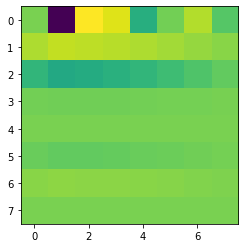

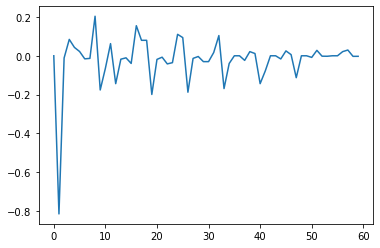

In [10]:
import scipy.fft

def dct2(a):
    return scipy.fft.dct( scipy.fft.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fft.idct( scipy.fft.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def dct_snake(shape1D):
    result = np.zeros((shape1D, shape1D), dtype=int) - 1
    isUpSnake = True
    currX = 0
    currY = 0
    i = 0
    while(True):
        #print(currX, currY)
        result[currY,currX] = i
        isOnTopEdge = currY == 0
        isOnLeftEdge = currX == 0
        isOnBottomEdge = currY == shape1D-1
        isOnRightEdge = currX == shape1D-1

        if(isOnBottomEdge and isOnRightEdge):
            return result

        if(isUpSnake):
            if(isOnTopEdge and isOnRightEdge):
                currY += 1
                isUpSnake = False
            elif(isOnTopEdge):
                currX += 1
                isUpSnake = False
            elif(isOnRightEdge):
                currY += 1
                isUpSnake = False
            else:
                currX += 1
                currY -= 1
        else:
            if(isOnBottomEdge and isOnLeftEdge):
                currX += 1
                isUpSnake = True
            elif(isOnLeftEdge):
                currY += 1
                isUpSnake = True
            elif(isOnBottomEdge):
                currX += 1
                isUpSnake = True
            else:
                currX -= 1
                currY += 1
        i += 1

def get_DCT_Coeffs(A, n):
    #precondition: n < (Area(A)/2)
    dim = A.shape[0]
    print(dct_snake(dim))
    snake_indicies = dct_snake(dim)
    
    dct_coeffs = dct2(A).ravel()
    snaked_coeffs = dct_coeffs.ravel()[snake_indicies].ravel()
    return snaked_coeffs[snake_indicies.ravel() < n]
    #valid_dct_coeffs = dct_coeffs[valid_snake_indicies]

    return dct_coeffs[valid_snake_indicies]



np.set_printoptions(suppress=True)
imsize = PCM.shape
print(imsize)
dct_coeffs = np.zeros(imsize)
BOI = dct2(PCM)

fig, ax = plt.subplots()
ax.imshow(BOI[:8, :8])
print(np.round(BOI[:4, :4], 4))

C = get_DCT_Coeffs(PCM, 60)

fig, ax = plt.subplots()
print(np.round(C, 4))
ax.plot(C)
#dct_snake(6)
